# Capstone Project: The Battle of Neighborhoods

# Table of Content

* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# 1. Introduction <a name="introduction"></a>

## 1.a Background Information


Gentrification is a common phenomenon happening in big and small cities. The question is: when/how is a neighbourhood starting its gentrification process? What attracts the newcomers? If we evaluate a neighbourhood by its rent price average and its current local businesses, then compare it to the similar and trendier neighbourhoods of that same city, could we predict what type of upcoming business should be the next one to establish itself, in order to kick-start the gentrification? In that way, could we help local councils choose which development project to choose, in order improve the life quality of their citizens?


## 1.b Problem statement

In this report, we will pick a neighbourhood of Cologne, Germany called Nippes, which is rather residential. We will put it against the other similar neighbourhoods of that same city with higher rent prices, then analyse what type of businesses would be hypothetically the next one to open up. 

## 1.c Target audience for this report

The information gathered from the web and its analysis will be a good basis to make an informed decision, when it comes to forecast what kind of business would be the best fit to improve a specific neighbourhood. In that case, entrepreneurs looking for inspiration, businesses looking to expand, or even city council members could welcome this report as valuable study.  

# 2. Data  <a name="data"></a>

## 2.a Description of the Data
We will base our research with the following data : 

* __Average price per m² per postal code in Cologne :__ This data is available through web scraping from this webpage : https://www.miet-check.de/mietpreise/plz/koeln/2243/ . For the sake of simplifying the processus of harvesting the data, it will be saved and stored in a csv file on Github. 

* __Name of neighbourhoods per postal code :__ This data is available through web scraping from this webpage : https://www.postleitzahlen.de/plz/koeln 

* __Population and Density per postal code :__ This data is available from this report from the City of Cologne : 
 1. Population : https://www.stadt-koeln.de/mediaasset/content/pdf15/statistik-standardinformationen/k%C3%B6lner_postleitzahlgebiete_strukturdaten_2016_si_3_2017.pdf

 2. Density : Per postal code https://www.suche-postleitzahl.org/koeln-plz-50667-51467.4c37

 3. For the sake of simplifying the processus of harvesting the data, both information will be handpicked and stored in a csv file on Github. 
 

* __Venues in all different neighbourhoods of Cologne :__ This information is gathered through Geocoder and Foursquare. Once we attach the proper GPS coordinates to each neighbourhood, we'll be able gather businesses in a radius from that GPS location.


## 2.b How will the data be used to solve the problem

1. __Processing of Data :__ We'll be gathering the data into panda dataframes from different web sources mentioned in __2.a__
2. __Clean dataset :__ If we are missing information such as rent prices for a specific postal code, we'll be using the average of that same neighbourhood from other postal codes. Then we'll be removing any NaN, should there be any left, and making sure that the relevant info stays into the datasets
3. __Exploratory data analysis :__ 
We will be using : 
    1. Graphs to look at the different rent prices 
    4. One hot encoding and K-Means will help us cluster the similar neighbourhoods into groups.
    
## 2.c Librairies
Here are the folloring librairies which will be useful for our analysis:

In [1]:
# Main Data Science Librairies
import requests 
import pandas as pd 
import numpy as np 
import random 
import itertools

#Graphs
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium

# Geocoder to get the GPS coordinates
from geopy.geocoders import Nominatim
import geocoder

# Display of images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# Json Files
from pandas.io.json import json_normalize

#K-means
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


## 2.d Data preparation
### 1) Get all postal codes of Cologne and their respective neighbourhood 

It was not possible to get the table on the website as a dataframe. So we saved the info in a csv file and uploaded into GitHub. 

In [2]:
url = 'https://github.com/simcht/Coursera_Capstone/blob/main/PostalCodeCologne.csv'
cologne_postalcode = pd.read_html(url)[0]
cologne_postalcode.head()

,Unnamed: 0,Postal_code,Neighbourhood
0,NaN,50667,Altstadt-Nord
1,NaN,50668,Altstadt-Nord
2,NaN,50670,Altstadt-Nord
3,NaN,50672,Altstadt-Nord
4,NaN,50733,Nippes


Let's clean the dataframe

In [3]:
cologne_postalcode = cologne_postalcode.drop('Unnamed: 0', axis=1)

cologne_postalcode["Postal_code"] = cologne_postalcode["Postal_code"].astype(int) 

cologne_postalcode.head()

,Postal_code,Neighbourhood
0,50667,Altstadt-Nord
1,50668,Altstadt-Nord
2,50670,Altstadt-Nord
3,50672,Altstadt-Nord
4,50733,Nippes


Let's merge all postal code duplicates so we can work per postal code zones.

In [4]:
cologne_postalcode = cologne_postalcode.groupby(['Postal_code'])['Neighbourhood'].apply(lambda x: ','.join(x.astype(str))).reset_index()

cologne_postalcode.head()

,Postal_code,Neighbourhood
0,50667,"Altstadt-Nord,Altstadt-Süd"
1,50668,"Altstadt-Nord,Neustadt-Nord"
2,50670,"Altstadt-Nord,Neustadt-Nord"
3,50672,"Altstadt-Nord,Neustadt-Nord"
4,50674,"Neustadt-Süd,Neustadt-Nord,Altstadt-Süd"


### 2) Get all rent prices per postal code

Let's upload the table with the rents.

In [5]:
url = 'https://www.miet-check.de/mietpreise/plz/koeln/2243/'
cologne_rent = pd.read_html(url)[0]
cologne_rent.head()

,#,PLZ,Mietpreis pro m2,Anzahl Einträge,Informationen
0,1,50667,15.94 Euro,185,mehr Infos
1,2,50668,17.29 Euro,405,mehr Infos
2,3,50670,16.47 Euro,428,mehr Infos
3,4,50672,18.42 Euro,393,mehr Infos
4,5,50674,16.92 Euro,395,mehr Infos


Let's clean the dataframe.

In [6]:
cologne_rent.drop(["#", "Anzahl Einträge", "Informationen"],  axis = 1, inplace = True)

cologne_rent.columns = ['Postal_code', 'Rent']

cologne_rent['Rent'] = cologne_rent['Rent'].str.replace(' Euro', '')

cologne_rent["Postal_code"] = pd.to_numeric(cologne_rent["Postal_code"])

cologne_rent['Rent'] = pd.to_numeric(cologne_rent['Rent'])

cologne_rent.head()

,Postal_code,Rent
0,50667,15.94
1,50668,17.29
2,50670,16.47
3,50672,18.42
4,50674,16.92


### 3) Get the population per postal code

Let's upload the table with the population.

In [7]:
url = 'https://github.com/simcht/Coursera_Capstone/blob/main/PopulationCologne.csv'
cologne_population = pd.read_html(url)[0]
cologne_population.head()

,Unnamed: 0,Postal_code,Population,km2,Density
0,NaN,50667,4615,1.27,3633.86
1,NaN,50668,12281,1.59,7723.90
2,NaN,50670,18122,1.89,9588.36
3,NaN,50672,9640,1.09,8844.04
4,NaN,50674,19385,1.43,13555.94


In [8]:
cologne_population = cologne_population.drop('Unnamed: 0', axis=1)

cologne_population["Postal_code"] = cologne_population["Postal_code"].astype(int) 
cologne_population["Population"] = pd.to_numeric(cologne_population["Population"])
cologne_population["km2"] = pd.to_numeric(cologne_population["km2"])
cologne_population["Density"] = pd.to_numeric(cologne_population["Density"])
cologne_population.head()

,Postal_code,Population,km2,Density
0,50667,4615,1.27,3633.86
1,50668,12281,1.59,7723.90
2,50670,18122,1.89,9588.36
3,50672,9640,1.09,8844.04
4,50674,19385,1.43,13555.94


### 4) Merge the dataframes together

In [9]:
#Merge postal code with rent dataframes
cologne_merged = cologne_postalcode.merge(cologne_rent, on=["Postal_code"])
cologne_merged.sort_values(by='Postal_code', inplace= True)
cologne_merged.reset_index(inplace = True)
cologne_merged.drop(["index"],  axis = 1, inplace = True)
cologne_merged.head(10)

,Postal_code,Neighbourhood,Rent
0,50667,"Altstadt-Nord,Altstadt-Süd",15.94
1,50668,"Altstadt-Nord,Neustadt-Nord",17.29
2,50670,"Altstadt-Nord,Neustadt-Nord",16.47
3,50672,"Altstadt-Nord,Neustadt-Nord",18.42
4,50674,"Neustadt-Süd,Neustadt-Nord,Altstadt-Süd",16.92
5,50676,Altstadt-Süd,16.02
6,50677,"Neustadt-Süd,Altstadt-Süd",16.76
7,50678,"Neustadt-Süd,Altstadt-Süd",17.50
8,50679,"Mülheim,Deutz",14.78
9,50733,"Nippes,Weidenpesch",15.55


In [10]:
#Merge population with postalcode/rent dataframes
cologne_merged = cologne_merged.merge(cologne_population, on=["Postal_code"])
cologne_merged.sort_values(by='Postal_code', inplace= True)
cologne_merged.reset_index(inplace = True)
cologne_merged.drop(["index"],  axis = 1, inplace = True)
cologne_merged.head(10)

,Postal_code,Neighbourhood,Rent,Population,km2,Density
0,50667,"Altstadt-Nord,Altstadt-Süd",15.94,4615,1.27,3633.86
1,50668,"Altstadt-Nord,Neustadt-Nord",17.29,12281,1.59,7723.90
2,50670,"Altstadt-Nord,Neustadt-Nord",16.47,18122,1.89,9588.36
3,50672,"Altstadt-Nord,Neustadt-Nord",18.42,9640,1.09,8844.04
4,50674,"Neustadt-Süd,Neustadt-Nord,Altstadt-Süd",16.92,19385,1.43,13555.94
5,50676,Altstadt-Süd,16.02,15842,1.37,11563.50
6,50677,"Neustadt-Süd,Altstadt-Süd",16.76,13789,1.06,13008.49
7,50678,"Neustadt-Süd,Altstadt-Süd",17.50,19158,1.46,13121.92
8,50679,"Mülheim,Deutz",14.78,15463,5.39,2868.83
9,50733,"Nippes,Weidenpesch",15.55,36526,3.06,11936.60


Let's check whether we have missing data anywhere. If this sums up to 0, it means all cells have information.

In [11]:
cologne_merged.isnull().sum(axis = 0)

Postal_code      0
Neighbourhood    0
Rent             0
Population       0
km2              0
Density          0
dtype: int64

### 4) Gather GPS coordinates for each neighbourhood

With the use of geocoder, let's harvest the GPS coordinates of each postal code and add them to the current dataframe.

In [12]:
##Define function that returns latitude and longitude 
def get_coordinates(postal_code):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Germany'.format(postal_code))
        lat_lng_coords = g.latlng
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    return latitude, longitude


#Loop through dataframe
for rownr in range(0,len(cologne_merged)):
    postal_code = cologne_merged.loc[rownr, 'Postal_code'] 
    latitude, longitude = get_coordinates(postal_code)
    cologne_merged.loc[cologne_merged.index[rownr], 'Latitude'] = latitude
    cologne_merged.loc[cologne_merged.index[rownr], 'Longitude'] = longitude

In [13]:
cologne_merged.head(10)

,Postal_code,Neighbourhood,Rent,Population,km2,Density,Latitude,Longitude
0,50667,"Altstadt-Nord,Altstadt-Süd",15.94,4615,1.27,3633.86,50.939020,6.953905
1,50668,"Altstadt-Nord,Neustadt-Nord",17.29,12281,1.59,7723.90,50.950230,6.961745
2,50670,"Altstadt-Nord,Neustadt-Nord",16.47,18122,1.89,9588.36,50.949745,6.944331
3,50672,"Altstadt-Nord,Neustadt-Nord",18.42,9640,1.09,8844.04,50.942165,6.934012
4,50674,"Neustadt-Süd,Neustadt-Nord,Altstadt-Süd",16.92,19385,1.43,13555.94,50.931635,6.933289
5,50676,Altstadt-Süd,16.02,15842,1.37,11563.50,50.930275,6.951211
6,50677,"Neustadt-Süd,Altstadt-Süd",16.76,13789,1.06,13008.49,50.920870,6.951421
7,50678,"Neustadt-Süd,Altstadt-Süd",17.50,19158,1.46,13121.92,50.923660,6.960874
8,50679,"Mülheim,Deutz",14.78,15463,5.39,2868.83,50.935033,6.982215
9,50733,"Nippes,Weidenpesch",15.55,36526,3.06,11936.60,50.964880,6.952868


### 5) Request venues information via FourSquare 


Now that we have the GPS coordinates of each postal code, let's gather information about the venues surrounding each respective GPS coordinates. 

In [14]:
CLIENT_ID = 'XVKYTNJ0UZ1ZANJU5TMXMV0TGX4MNKV3TUD0E5Y2JB5FCVOQ' # Foursquare ID
CLIENT_SECRET = 'R5PGTISFZ5KZLAYHUFU3GLWPR1IPJ50YKKTH54UBCWPYPN1W' # Foursquare Secret
VERSION = '20200120' # Foursquare API version
LIMIT = 75 # limit of number of venues returned by Foursquare API
radius = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XVKYTNJ0UZ1ZANJU5TMXMV0TGX4MNKV3TUD0E5Y2JB5FCVOQ
CLIENT_SECRET:R5PGTISFZ5KZLAYHUFU3GLWPR1IPJ50YKKTH54UBCWPYPN1W


Let's define the function that will gather the venues per neighbourhood

In [15]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal_code', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
cologne_venues = getNearbyVenues(names=cologne_merged['Postal_code'],
                                   latitudes=cologne_merged['Latitude'],
                                   longitudes=cologne_merged['Longitude']
                                   )

In [17]:
cologne_venues.head(15)

,Postal_code,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,50667,50.93902,6.953905,KOLUMBA Kunstmuseum,50.938530,6.954084,Art Museum
1,50667,50.93902,6.953905,Sattgrün,50.938441,6.954965,Vegetarian / Vegan Restaurant
2,50667,50.93902,6.953905,Espresso Perfetto,50.938852,6.953973,Coffee Shop
3,50667,50.93902,6.953905,REWE Richrath,50.938520,6.950774,Supermarket
4,50667,50.93902,6.953905,MUJI,50.939165,6.955877,Miscellaneous Shop
5,50667,50.93902,6.953905,Fanshop 1. FC Köln,50.936579,6.953707,Sporting Goods Shop
6,50667,50.93902,6.953905,LEGO Store,50.937042,6.956564,Toy / Game Store
7,50667,50.93902,6.953905,Apple Schildergasse,50.936552,6.955877,Electronics Store
8,50667,50.93902,6.953905,Vinoteca da Rino,50.938629,6.953072,Italian Restaurant
9,50667,50.93902,6.953905,Fitness First,50.936639,6.951151,Gym / Fitness Center


In [18]:
cologne_venues.shape

(1482, 7)

1482 different venues found, split into their respective neighbourhood

So far, we have gathered all necessary data into 2 different dataframes: 
1. __cologne_merged:__ Contains every names, rent prices, population, area, density and GPS coordinates of every postal codes of Cologne

2. __cologne_venues:__ Contains venues gelocated nearby the initial GPS coordinates of each postal code, up to a maxium of 75 venues. 

Since our data is ready to be analyze, we'll proceed to the next step : 

# 3. Methodology - Exploratory data analysis <a name="methodology"></a>

## 3.a The rent analysis

### 1) Histogram

Let's start by visualizing the rent distribution in Cologne via a histogram. Let's single out our target neighbourhood with a red line

Text(0, 0.5, 'Frequency')

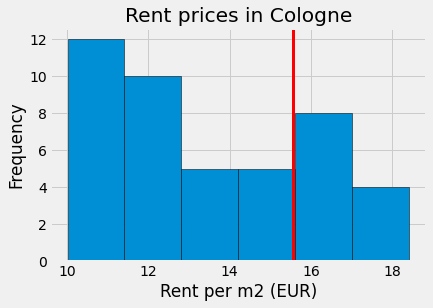

In [19]:
x = cologne_merged['Rent'] 
nippes_rent = cologne_merged.loc[cologne_merged['Postal_code'] == 50733, 'Rent'].iloc[0]

plt.style.use('fivethirtyeight')
plt.hist(x, bins = 6, edgecolor='black' )
plt.axvline(nippes_rent, color = 'red', label = 'Rent Nippes', linewidth= 3)

plt.title('Rent prices in Cologne')
plt.xlabel('Rent per m2 (EUR)')
plt.ylabel('Frequency')

In [20]:
print('The average rent in Nippes is {} EUR per m2'.format(nippes_rent))

The average rent in Nippes is 15.55 EUR per m2


As you can see, it's on the verge of joining the upper 2 brackets of the rent prices in Cologne.

### 2) Folium Map - Rent <a name="rentmap"></a>
Now let's take our brackets and assign them colours. We'll push them onto a Folium Map to visually see the distribution. Let's also check the different brackets and their counts. We'll have colours following traffic lights, starting at green for the lowest rent prices, all the way up to red and firebrick for the most expensive rents.

In [21]:
colours_rent = [ 'green', 'yellow', 'gold', 'darkorange', 'red', 'firebrick']
cologne_merged['Colour_Rent'] = pd.cut(cologne_merged['Rent'], bins=6, labels = colours_rent)
cologne_rent_bracket = pd.cut(cologne_merged['Rent'], bins=6,).value_counts().to_frame()
cologne_rent_bracket.reset_index(inplace = True)
cologne_rent_bracket.columns = ['Bracket', 'Count']
cologne_rent_bracket.sort_values(by=['Bracket'], inplace = True )
cologne_rent_bracket['Colour'] = colours_rent
cologne_rent_bracket

,Bracket,Count,Colour
0,"(10.002, 11.412]",12,green
1,"(11.412, 12.813]",10,yellow
4,"(12.813, 14.215]",5,gold
3,"(14.215, 15.617]",5,darkorange
2,"(15.617, 17.018]",8,red
5,"(17.018, 18.42]",4,firebrick


Now let's draw a map and pin point each neighbourhood with the colour of their respective bracket. 

In [22]:
# Let's center the map on Cologne's Cathedral. The streets revolve around it like concentric circles.
kolner_dom = [50.941278, 6.958281]
cologne_rent_map = folium.Map(location=[kolner_dom[0], kolner_dom[1]], zoom_start=11)
cologne_merged['Postal_code'] = cologne_merged['Postal_code'].astype(str)
cologne_merged['Rent'] = cologne_merged['Rent'].astype(str)

#Add the neighbourhoords based on their rent prices
for index, row in cologne_merged.iterrows():
    folium.CircleMarker([row['Latitude'], 
                         row['Longitude']],
                         radius=5, 
                         color=row['Colour_Rent'], 
                         fill=True,
                         popup=(row['Postal_code'] + ", " + row['Neighbourhood'] + ", " + row['Rent'] + " EUR/m2"),
                         fill_color=row['Colour_Rent'],
                         fill_opacity=1
                       ).add_to(cologne_rent_map)

cologne_rent_map

We can obviously witness a correlation between the proximity to downtown and the rent prices. Three interesting things : 

1 - Living right __"In the core of the old town"__ (__50667__ (Altstadt-Nord) & __50676__ (Altstadt-Süd) - red pins in the center) is not as expensive as living __"Inside the Neustadt, but outside the old town"__ (__50668__ (Neustadt-Nord), __50672__ (Neustadt-Nord) & __50678__ (Neudstadt-Süd) - firebrick colour pins in peripheral).

2 - Even though __50679__ (Mülheim, Deutz - orange dot on the right) is probably transitioning into being gentrified, there's an obvious and drastic difference of price, should one cross the Rhine. If you ask a local, they all have a theory about it. It even goes way back to Roman times 2000 years ago, when the barbaric tribes (Germanen) would live across the Rhine. 

3 - __50968__ (Marienburg - the firebrick pin at the bottom of the map) is an obivous outlier. There is an historical reason behind it. At the end of the 19th century, over a period of around 30 years, a great interest in this neighbourhood from many architects of the time arose, which resulted in the development of a large number of palatial buildings. The development was largely completed by 1925 and was called "The villa area". 

After World War 2, Bonn became the seat of government of the Federal Republic of Germany in 1949 and Marienburg became the location of some residences of foreign diplomatic missions and embassies. Still today, the villa area of Marienburg is a residential area characterized by magnificent buildings from the turn of the century, with extensive gardens, avenues and parks.

## 3.b The density analysis 

### 1) Histogram

Let's start by visualizing the density distribution in Cologne via a histogram. Let's single out our target neighbourhood with a red line

Text(0, 0.5, 'Frequency')

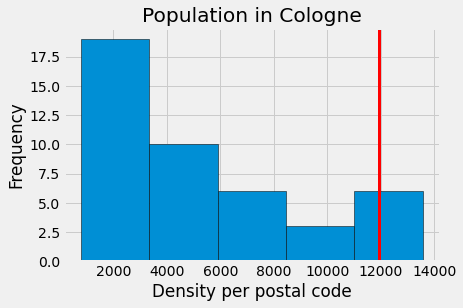

In [23]:
y = cologne_merged['Density'] 
nippes_density = cologne_merged.loc[cologne_merged['Postal_code'] == '50733', 'Density'].iloc[0]

plt.style.use('fivethirtyeight')
plt.hist(y, bins = 5, edgecolor='black' )
plt.axvline(nippes_density, color = 'red', label = 'Density Nippes', linewidth= 3)

plt.title('Population in Cologne')
plt.xlabel('Density per postal code')
plt.ylabel('Frequency')

In [24]:
print('The density in Nippes is {} inhabitants/km2'.format(nippes_density))

The density in Nippes is 11936.6 inhabitants/km2


As you can see, Nippes is amonsgt the most dense neighbourhoods of Cologne

### 2) Folium Map - Density <a name="densitymap"></a>
Now let's take our brackets and assign them colours. We'll push them onto a Folium Map to visually see the distribution. Let's also check the different brackets and their counts. We'll have colours following traffic lights, starting at green for the lowest populated area, all the way up to red and marroon for the most populated.

In [25]:
colours_density = [ 'green', 'yellow', 'darkorange', 'red', 'firebrick']
cologne_merged['Colour_Density'] = pd.cut(cologne_merged['Density'], bins=5, labels = colours_density)
cologne_density_bracket = pd.cut(cologne_merged['Density'], bins=5,).value_counts().to_frame()
cologne_density_bracket.reset_index(inplace = True)
cologne_density_bracket.columns = ['Bracket', 'Count']
cologne_density_bracket.sort_values(by=['Bracket'], inplace = True )
cologne_density_bracket['Colour'] = colours_density
cologne_density_bracket

,Bracket,Count,Colour
0,"(770.808, 3338.052]",19,green
1,"(3338.052, 5892.524]",10,yellow
3,"(5892.524, 8446.996]",6,darkorange
4,"(8446.996, 11001.468]",3,red
2,"(11001.468, 13555.94]",6,firebrick


Now let's draw a map and pin point each neighbourhood with the colour of their respective bracket. 

In [26]:
# Let's center the map on Cologne's Cathedral. The streets revolve around it like concentric circles.
kolner_dom = [50.941278, 6.958281]
cologne_density_map = folium.Map(location=[kolner_dom[0], kolner_dom[1]], zoom_start=11)
cologne_merged['Postal_code'] = cologne_merged['Postal_code'].astype(str)
cologne_merged['Density'] = cologne_merged['Density'].astype(str)

#Add the neighbourhoords based on their rent prices
for index, row in cologne_merged.iterrows():
    folium.CircleMarker([row['Latitude'], 
                         row['Longitude']],
                         radius=5, 
                         color=row['Colour_Density'], 
                         fill=True,
                         popup=(row['Postal_code'] + ", " + row['Neighbourhood'] + ", " + row['Density'] + ' inhabitants/km2'),
                         fill_color=row['Colour_Density'],
                         fill_opacity=1
                       ).add_to(cologne_density_map)

cologne_density_map

The correlation between the proximity to downtown and the density is quite obvious here, it decreases with radial distance to downtown. Some interesting facts : 

1.  Two postal codes have a smaller density than expected. This can be explained by : 

 __50667__ ((Alstadt-Nord - yellow pin in the middle)): The presence of many hotels, squares, cathedrals, restaurants which take up the space instead of residential streets.
 
 __50679__ ((Mülheim - green pin in the middle)): The presence of Deutz Messe (Cologne trade fair), arenas, hotels which take up the space instead of residential streets.


2. All denser postal codes are within a close proximity to the Grüngürtel, a group of parks which surrounds the Neustadt. 


## 3.c The venues analysis

Now that we have a good visual of the spread of the rent prices and density in Cologne, now let's have a look at the venues we harvested from Foursquare. We'll be able to find correlation between all neighbourhoods through their type of venues and find which neighbourhoods have more in common with Nippes. 

### 1) Number of venues per postal code
First, let's see how many venues were harvested per postal code.

In [27]:
cologne_venues.groupby('Postal_code').count().head(10)

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal_code,,,,,,
50667,75,75,75,75,75,75
50668,75,75,75,75,75,75
50670,75,75,75,75,75,75
50672,75,75,75,75,75,75
50674,75,75,75,75,75,75
50676,75,75,75,75,75,75
50677,46,46,46,46,46,46
50678,75,75,75,75,75,75
50679,74,74,74,74,74,74


We can see that we have some neighbourhoods which easily reached the max of 75 venues, where others could not reach the maximum. That can be explained by the fact that those postal codes have their venues further out from the epicenter, meaning that they are more spread out, and unfortunately provided less venues. Let's see the number of unique categories of venues. 

In [28]:
print('There are {} uniques categories.'.format(len(cologne_venues['Venue Category'].unique())))

There are 232 uniques categories.


### 2) One-hot Encoding 
Now let's use the one-hot encoding technique to deal with the categorical data (the categories of venues). 

In [29]:
# one hot encoding
cologne_onehot = pd.get_dummies(cologne_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cologne_onehot['Postal_code'] = cologne_venues['Postal_code'] 

# move neighborhood column to the first column
fixed_columns = [cologne_onehot.columns[-1]] + list(cologne_onehot.columns[:-1])
cologne_onehot = cologne_onehot[fixed_columns]

cologne_onehot.head(10)

,Postal_code,ATM,Airport,Airport Service,Airport Terminal,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,50667,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50667,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,50667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,50667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,50667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,50667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,50667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,50667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



### 3) Top 10 categories per postal code
By summing the one-hot encoding per categories and per postal codes, it will allow us to see which categories have a higher frequencies within specific postal codes, in relations to the whole city. The following steps will display a top 10 categories of each postal code and their frequencies. 


In [30]:
cologne_grouped = cologne_onehot.groupby('Postal_code').mean().reset_index()

In [31]:
# Let's put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
# Now let's create the new dataframe and display the top 5 venues for each neighborhood.
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal_code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cologne_venues_sorted = pd.DataFrame(columns=columns)
cologne_venues_sorted['Postal_code'] = cologne_grouped['Postal_code']

for ind in np.arange(cologne_grouped.shape[0]):
    cologne_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cologne_grouped.iloc[ind, :], num_top_venues)

cologne_venues_sorted

,Postal_code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,50667,Hotel,Plaza,Art Museum,Italian Restaurant,Pedestrian Plaza,Café,Gym / Fitness Center,Coffee Shop,Clothing Store,Sushi Restaurant
1,50668,Café,Italian Restaurant,Hotel,Turkish Restaurant,Coffee Shop,French Restaurant,German Restaurant,Movie Theater,Pizza Place,Bakery
2,50670,Italian Restaurant,Turkish Restaurant,Bar,Park,Café,Spanish Restaurant,Hotel,French Restaurant,Burger Joint,Record Shop
3,50672,Café,Cocktail Bar,Hotel,Restaurant,Bar,Sushi Restaurant,Bakery,Plaza,Breakfast Spot,Park
4,50674,Café,Italian Restaurant,Cocktail Bar,Bar,Nightclub,Greek Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Tapas Restaurant,Thai Restaurant
5,50676,Italian Restaurant,Hotel,Café,German Restaurant,Sushi Restaurant,Event Space,Restaurant,Pub,Hostel,Nightclub
6,50677,Italian Restaurant,Café,Bakery,French Restaurant,Plaza,Restaurant,Sushi Restaurant,Ice Cream Shop,Salad Place,Supermarket
7,50678,Café,Plaza,French Restaurant,Italian Restaurant,German Restaurant,Restaurant,Bar,Theater,Sushi Restaurant,Movie Theater
8,50679,Restaurant,Hotel,Bakery,Tram Station,BBQ Joint,Café,Platform,Pizza Place,German Restaurant,Supermarket
9,50733,Supermarket,Café,Park,Italian Restaurant,Bakery,Bar,Plaza,Doner Restaurant,Bookstore,Greek Restaurant


### 4) KMeans
Now that we have one-hot coded all categories to all postal codes, we'll be able to use KMeans. It is an iterative Machine learning technique that tries to partition the dataset into K-pre-defined distinct non-overlapping clusters where each data point belongs to only one cluster. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different as possible.

First step is to decide how many clusters we will require. 

In [44]:
Sum_of_squared_distances = []
K = range(1,15)
cologne_clustering = cologne_grouped.drop('Postal_code', 1)
for k in K:
    km = KMeans(n_clusters=k, random_state=7).fit(cologne_clustering)
    Sum_of_squared_distances.append(km.inertia_)

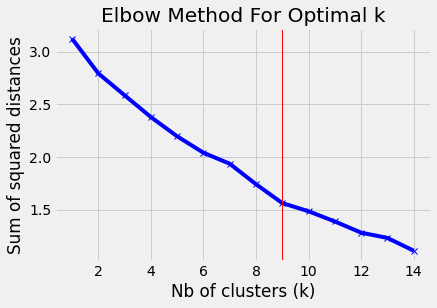

In [45]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Nb of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.axvline(9, color = 'red', label = 'Elbow', linewidth= 1)
plt.show()

k = 9 is the most visible "elbow", meaning that we will cluster the postal codes into 9 different groups. 

In [46]:
# Run k-means to cluster the neighbourhood into clusters.
# set number of clusters
kclusters = 9

cologne_clustering = cologne_grouped.drop('Postal_code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=5).fit(cologne_clustering)

# check cluster labels generated for each row in the dataframe
labels = pd.DataFrame(kmeans.labels_)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 6, 4, 2, 3, 2, 1, 1, 2, 4, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 0, 5, 5, 2, 2, 2, 7, 2, 4, 8, 2, 2, 2, 2, 2])

### 5) Folium map - The Clusters  <a name="clustermap"></a>

Now that we know which postal code belongs to which cluster, let's map them out with different colours. 

In [47]:
# Bring together cologne_merged with the top 10 and the cluster class
cologne_merged['Postal_code'] = cologne_venues_sorted['Postal_code']
cologne_merged['Cluster Labels'] = labels
cologne_merged = cologne_merged.merge(cologne_venues_sorted, how = 'left')
cologne_merged.head()

,Postal_code,Neighbourhood,Rent,Population,km2,Density,Latitude,Longitude,Colour_Rent,Colour_Density,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,50667,"Altstadt-Nord,Altstadt-Süd",15.94,4615,1.27,3633.86,50.939020,6.953905,red,yellow,...,Hotel,Plaza,Art Museum,Italian Restaurant,Pedestrian Plaza,Café,Gym / Fitness Center,Coffee Shop,Clothing Store,Sushi Restaurant
1,50668,"Altstadt-Nord,Neustadt-Nord",17.29,12281,1.59,7723.9,50.950230,6.961745,firebrick,darkorange,...,Café,Italian Restaurant,Hotel,Turkish Restaurant,Coffee Shop,French Restaurant,German Restaurant,Movie Theater,Pizza Place,Bakery
2,50670,"Altstadt-Nord,Neustadt-Nord",16.47,18122,1.89,9588.36,50.949745,6.944331,red,red,...,Italian Restaurant,Turkish Restaurant,Bar,Park,Café,Spanish Restaurant,Hotel,French Restaurant,Burger Joint,Record Shop
3,50672,"Altstadt-Nord,Neustadt-Nord",18.42,9640,1.09,8844.04,50.942165,6.934012,firebrick,red,...,Café,Cocktail Bar,Hotel,Restaurant,Bar,Sushi Restaurant,Bakery,Plaza,Breakfast Spot,Park
4,50674,"Neustadt-Süd,Neustadt-Nord,Altstadt-Süd",16.92,19385,1.43,13555.94,50.931635,6.933289,red,firebrick,...,Café,Italian Restaurant,Cocktail Bar,Bar,Nightclub,Greek Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Tapas Restaurant,Thai Restaurant


In [51]:
# Let's center the map on Cologne's Cathedral
kolner_dom = [50.941278, 6.958281]
cologne_cluster_map = folium.Map(location=[kolner_dom[0], kolner_dom[1]], zoom_start=11)
colour_six = [ 'magenta', 'firebrick', 'red', 'blue', 'orange', 'yellow','purple', 'green', 'cyan']
cologne_merged['Postal_code'] = cologne_merged['Postal_code'].astype(str)

#Add the neighbourhoords based on their rent prices
for index, row in cologne_merged.iterrows():
    folium.CircleMarker([row['Latitude'], 
                         row['Longitude']],
                         radius=5, 
                         color=colour_six[row['Cluster Labels']], 
                         fill=True,
                         popup=(row['Postal_code'] + " " + row['Neighbourhood']),
                         fill_color=colour_six[row['Cluster Labels']],
                         fill_opacity=1
                       ).add_to(cologne_cluster_map)

cologne_cluster_map

 Colour         | Name        | Description                  | 
----------------|-------------|------------------------------|
Firebrick       |City Cluster | City + S-Bahn                |
Red             | Suburbs	  | Access to KvB and/or S-Bahn  |  
Orange & Yellow | Suburbs     | End of lines of KvB          |
Other           | Outliers    | Blue, Purple, Green, Cyan, Magenta |

No surprises here. Postal codes closer to the city center tend to belong to the same cluster, meaning there is a correlation between their types of venues. Let's call this firebrick-coloured cluster : __"The city cluster"__. 

The Regio/S-Bahn train network (dark grey lines) seems to help suburbs and their venues develop like in the city :
1. __50933__ (Müngersdorf), __50939__ (Klettenberg), which should have been technically red or yellow, are part of __the city cluster__ and therefore has venues similar to the city.

The KvB train network (light grey lines) seems to support help correlate the red cluster and its venues: 
1. It's mostly visible with __50859__ (Lövenich), __51063__ (Mülheim) and __51109__ (Brück). 

The outliers (Blue, Purple, Green, Cyan, Magenta) are the ones rather distant from downtown and/or not directly deserved by train tracks. They went their own way when it comes to their venues. They are also different from one another.



# 4. Results: <a name="results"></a>

## 4a) Nippes

In [52]:
cologne_merged.loc[cologne_merged['Postal_code'] == '50733' , ['Postal_code', 'Neighbourhood', 'Colour_Rent', 'Colour_Density', 'Cluster Labels']]

,Postal_code,Neighbourhood,Colour_Rent,Colour_Density,Cluster Labels
9,50733,"Nippes,Weidenpesch",darkorange,firebrick,1


Here are all scores for Nippes : 
1. 3rd bracket in Rent prices (__darkorange__). We'll investigate the postal codes in the 2 upper brackets __red__ and __firebrick__ 
2. 1st bracket in density (__firebrick__). We'll investigate the postal codes in the current bracket __firebrick__.
3. __City Cluster__ in clusters. We'll investigate within the __city cluster__. 

## 4b) The finalists
Here are the postal codes which fit all criteria.

In [53]:
cologne_narrow_down = cologne_merged.loc[(cologne_merged['Cluster Labels'] == 1) & 
                                            ((cologne_merged['Colour_Rent'] == 'red') | 
                                             (cologne_merged['Colour_Rent'] =='firebrick')) &
                                            (cologne_merged['Colour_Density'] =='firebrick')]
cologne_narrow_down

,Postal_code,Neighbourhood,Rent,Population,km2,Density,Latitude,Longitude,Colour_Rent,Colour_Density,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,50674,"Neustadt-Süd,Neustadt-Nord,Altstadt-Süd",16.92,19385,1.43,13555.94,50.931635,6.933289,red,firebrick,...,Café,Italian Restaurant,Cocktail Bar,Bar,Nightclub,Greek Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Tapas Restaurant,Thai Restaurant
5,50676,Altstadt-Süd,16.02,15842,1.37,11563.5,50.930275,6.951211,red,firebrick,...,Italian Restaurant,Hotel,Café,German Restaurant,Sushi Restaurant,Event Space,Restaurant,Pub,Hostel,Nightclub
6,50677,"Neustadt-Süd,Altstadt-Süd",16.76,13789,1.06,13008.49,50.920870,6.951421,red,firebrick,...,Italian Restaurant,Café,Bakery,French Restaurant,Plaza,Restaurant,Sushi Restaurant,Ice Cream Shop,Salad Place,Supermarket
7,50678,"Neustadt-Süd,Altstadt-Süd",17.5,19158,1.46,13121.92,50.923660,6.960874,firebrick,firebrick,...,Café,Plaza,French Restaurant,Italian Restaurant,German Restaurant,Restaurant,Bar,Theater,Sushi Restaurant,Movie Theater


Now that we have the potential postal codes to be inspired from, let's sum up all of their top 10 categories and see what comes up the most frequently. 

## 4c) The Top 5 venues

In [58]:
categories_list = []
for x in range(0,len(cologne_narrow_down)):
    for y in range(0,10):
        categories_list.append(cologne_narrow_down.iloc[x][y+11])
categories = pd.DataFrame(categories_list)
categories = categories.stack().value_counts().to_frame()
categories.columns = ['Count']
categories.head(10)

,Count
Italian Restaurant,4
Café,4
Restaurant,3
Sushi Restaurant,3
Plaza,2
German Restaurant,2
Bar,2
French Restaurant,2
Nightclub,2
Movie Theater,1


Here are the values for Nippes, in a dataframe : 

In [59]:
nippes = cologne_merged.loc[cologne_merged['Postal_code'] == '50733']
nippes

,Postal_code,Neighbourhood,Rent,Population,km2,Density,Latitude,Longitude,Colour_Rent,Colour_Density,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,50733,"Nippes,Weidenpesch",15.55,36526,3.06,11936.6,50.96488,6.952868,darkorange,firebrick,...,Supermarket,Café,Park,Italian Restaurant,Bakery,Bar,Plaza,Doner Restaurant,Bookstore,Greek Restaurant


Let's subtract the current categories, in order to be left with the type of venues missing in Nippes. 

In [60]:
for x in range(0,10):
    if nippes.iloc[0,x + 11] in categories.index :
        categories = categories.drop(index = nippes.iloc[0,x + 11])
    elif 'Restaurant' in categories.index : 
        categories = categories.drop(index = 'Restaurant') #to avoid redundancy and make sure the type of restaurant is clear
categories.head(5)

,Count
Sushi Restaurant,3
German Restaurant,2
French Restaurant,2
Nightclub,2
Movie Theater,1


# 5. Discussion <a name="discussion"></a>

Different analysis have been performed to find the ideal upcoming top 5 venues for Nippes, Cologne. 
We considered rent prices, population density, and clusters of postal codes with similar venues. By narrowing it down based on those analysis, we ended up with a final group of 4 postal codes from which we could get inspired. Then we summed up their top 10s and sorted them by frequency. After subtracting the top 10 venues already existing in Nippes, we could find out that the following are the potential ideal venues for Nippes: 
*	Sushi restaurant
*	German restaurant
*	French restaurant
*	Nightclub
*	Movie Theatre


Those recommendations are based on the precision of the tools we used. At some point, we realized that the Foursquare API was not providing any results for the postal code 50769 Fühlingen-Roggendorf, so we had to take it out of the research. It was not at a great loss, since the majority of the postal code’s area is a Ford factory and a golf course. 


The KMeans analysis required some tuning when it came to decide the number of clusters to use. The variation was not that steep enough to find a significant winner, although we did pick the number of cluster with the highest slope (9 clusters). 


There are also other factors which could have been taken into account, i.e. the average income per household, properties to sell within Nippes for business purposes, parking lots location, etc. 


# 6. Conclusion <a name="conclustion"></a>



These recommended venues are a good starting point for further analysis for entrepreneurs looking for inspiration, businesses looking to expand, or even city council members looking to improve the lifestyle of their citizens. 

As you may have realized with this quick analysis, a lot can be interpreted from data from many sources. Let’s make sure we provide our decision makers with accurate data and relevant analysis for the benefit of our neighbours and fellow citizens. 
